# 11 in-situ TPA
The in-situ Transfer Path Analysis (TPA) is a method where equivalent forces can be determined by means of in-situ characterisation. First step is to measure FRFs  $\textbf{Y}_{42}$ on the passive system and the second to measure response $\textbf{u}_4$ (indicator sensors) with active source. Equivalent forces can then be calculated as:
$\textbf{f}_{\text{eq}} = (\textbf{Y}_{42})^{-1} \textbf{u}_4.$


In [2]:
import pyFBS

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm
from matplotlib import cm

#### Example Datasests
Load the required predefined datasets:

In [3]:
pyFBS.download_lab_testbench()

100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 7133.17it/s]

In [4]:
pos_xlsx = r"./lab_testbench/Measurements/TPA_synt.xlsx"

stl_dir_A = r"./lab_testbench/STL/A.stl"
stl_dir_B = r"./lab_testbench/STL/B.stl"
stl_dir_AB = r"./lab_testbench/STL/AB.stl"

df_acc_AB = pd.read_excel(pos_xlsx, sheet_name='Sensors_AB')
df_chn_AB = pd.read_excel(pos_xlsx, sheet_name='Channels_AB')
df_imp_AB = pd.read_excel(pos_xlsx, sheet_name='Impacts_AB')

#### 3D view
Open 3D viewer in the background.

In [5]:
view3D = pyFBS.view3D()

Display AB structure and sensors, channels and impacts.

In [6]:
view3D.plot.add_text("AB structure", position='upper_left', font_size=10, color="k", font="times", name="AB_structure");

_ = view3D.add_stl(stl_dir_B,name = "B");
_ = view3D.add_stl(stl_dir_A,color = "#83afd2",name = "A");

view3D.show_acc(df_acc_AB)
view3D.show_imp(df_imp_AB)
view3D.show_chn(df_chn_AB)

#### Numerical model
Load the corresponding .full and .ress file from the example datasets. For more information on .full and .ress files refer to the *03_FRF_synthetization.ipynb* example

In [7]:
full_file_AB = r"./lab_testbench/FEM/AB.full"
ress_file_AB = r"./lab_testbench/FEM/AB.rst"

Create an MK model for each component:

In [8]:
MK_AB = pyFBS.MK_model(ress_file_AB,full_file_AB,no_modes = 100,allow_pickle= True,recalculate = False)

C:\Users\tomaz.bregar\Anaconda3\lib\site-packages\pyvista\core\pointset.py:610: UserWarning: VTK 9 no longer accepts an offset array
  warnings.warn('VTK 9 no longer accepts an offset array')


Update locations of channels and impacts to snap to the nearest FE node.

In [9]:
df_chn_AB_up = MK_AB.update_locations_df(df_chn_AB)
df_imp_AB_up = MK_AB.update_locations_df(df_imp_AB)

Perform the FRF sythetization for each component based on the updated locations.

In [10]:
MK_AB.FRF_synth(df_chn_AB_up,df_imp_AB_up,f_start = 0,f_end = 10000,f_resolution = 1,modal_damping = 0.003,frf_type = "receptance")

freq = MK_AB.freq
FRF = MK_AB.FRF

#### Virtual point transformation

Prepare the reduction matrices for the VPT.

In [11]:
df_vp = pd.read_excel(pos_xlsx, sheet_name='VP_Channels')
df_vpref = pd.read_excel(pos_xlsx, sheet_name='VP_RefChannels')

vpt_AB = pyFBS.VPT(df_chn_AB_up,df_imp_AB_up,df_vp,df_vpref)

## Application of the in-situ TPA



To simplify the measurement of the $\textbf{Y}_{42}$ the VPT can be applied on the interface excitation to transform forces at the interface into virtual DoFs (from $\textbf{Y}_{\text{uf}}$ to $\textbf{Y}_{\text{um}}$). Therefore, the interface is loaded with three forces ($F_x$, $F_y$, $F_z$) and ($M_x$, $M_y$, $M_z$)  

In [12]:
Y_um = FRF @ vpt_AB.Tf

Select operational DoFs $\textbf{u}_4$ and indicator DoFs $\textbf{u}_3$

In [13]:
select_op = 10

u4_op = MK_AB.FRF[:,:9,select_op:select_op+1]
u3_op = MK_AB.FRF[:,9:,select_op:select_op+1]

Calculate blocked forces $\textbf{f}_{\text{eq}}$  at the interface

In [14]:
f_eq = np.linalg.pinv(Y_um[:,:9,:6])@u4_op

TPA prediction at theinterface

In [15]:
_Y_temp = Y_um[:,9:,:6]
u3_tpa = _Y_temp@f_eq

On-board validation: comparison of predicted $\textbf{u}_3^{\text{TPA}}$ and operational $\textbf{u}_3^{\text{op}}$.

(0.0, 2000.0)

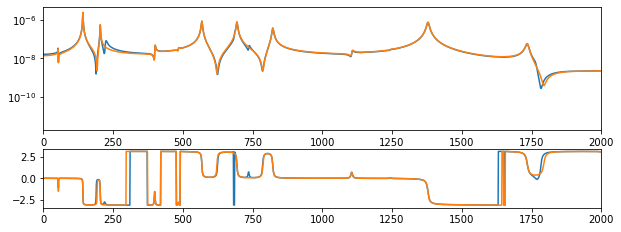

In [16]:
sel_out = 7

plt.figure(figsize = (10,5))

plt.subplot(211)
plt.semilogy(freq,np.abs(u3_tpa[:,sel_out,0]))
plt.semilogy(freq,np.abs(u3_op[:,sel_out,0]))
plt.xlim(0,2000)


plt.subplot(413)
plt.plot(freq,np.angle(u3_tpa[:,sel_out,0]))
plt.plot(freq,np.angle(u3_op[:,sel_out,0]))
plt.xlim(0,2000)


### Partial Transfer Paths

Partial transfer path can be calculated and evaluated.

In [17]:
sel_i = 1
u_partial = []

for j in range(6):
    gg = _Y_temp[:,sel_i:sel_i+1,j:j+1]@f_eq[:,j:j+1,0:1]
    u_partial.append(gg[:,0,0])
    
u_partial = np.asarray(u_partial).T

An intuitive way to look at the contribution of each path is looking on 

Text(0.5, 0, 'Frequency [Hz]')

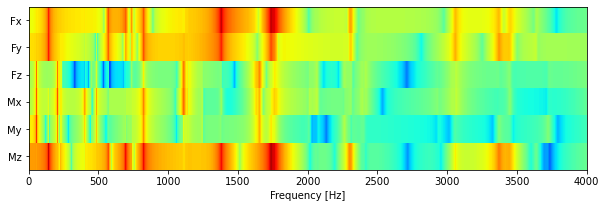

In [18]:
plt.figure(figsize = (10,3))

values = np.abs(u_partial).T
plt.imshow(values,interpolation='nearest', cmap=cm.jet,norm=LogNorm(vmin=np.min(values), vmax=np.max(values)),aspect = 'auto')

plt.xlim(0,4000)

plt.yticks(range(6),["Fx","Fy","Fz","Mx","My","Mz"])
plt.xlabel("Frequency [Hz]")

## Auralization

The predicted response or each path contribution can be evaluated by listening to synthetised time response. Within `pyFBS` auralization can be performed with ease and the response can be played within Jupyter notebook with single line of code.

In [19]:
import IPython.display as ipd

Auralization of the operational response $\textbf{u}_3^{\text{op}}$.

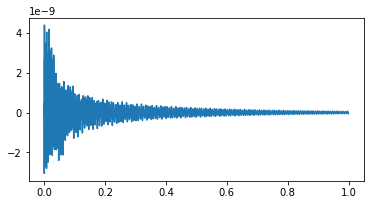

In [20]:
xt,s_op = pyFBS.auralization(freq,u3_op[:,sel_out,0])
plt.figure(figsize = (6,3))
plt.plot(xt,s_op)

ipd.Audio(s_op, rate=1/(xt[1]-xt[0])) 

Auralization of predicted response $\textbf{u}_3^{\text{TPA}}$.

Text(0, 0.5, 'Amplitude')

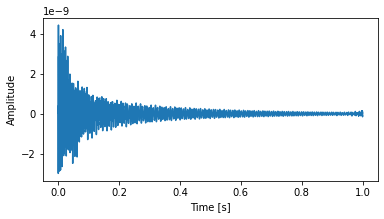

In [21]:
xt,s_tpa = pyFBS.auralization(freq,u3_tpa[:,sel_out,0])

plt.figure(figsize = (6,3))
plt.plot(xt,s_tpa)
ipd.Audio(s_tpa, rate=1/(xt[1]-xt[0])) 

plt.xlabel("Time [s]")
plt.ylabel("Amplitude")

Side-by-side comparison of operational $\textbf{u}_3^{\text{op}}$ and predicted $\textbf{u}_3^{\text{TPA}}$ response in time domain.

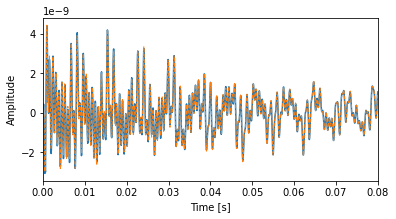

In [22]:
plt.figure(figsize = (6,3))
plt.plot(xt,s_op)
plt.plot(xt,s_tpa,'--',linewidth = 1)

plt.xlim(0,.08)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude");